<a href="https://colab.research.google.com/github/AkashKoley012/Computer-Vision-Projects/blob/main/Face%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
!kaggle datasets download -d andrewmvd/face-mask-detection

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection
License(s): CC0-1.0
 98% 391M/398M [00:05<00:00, 94.6MB/s]
100% 398M/398M [00:05<00:00, 70.5MB/s]


In [50]:
import zipfile
with zipfile.ZipFile('/content/face-mask-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('face-mask')

In [51]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from PIL import Image

import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [52]:
os.remove('/content/face-mask-detection.zip')

In [53]:
img_path = '/content/face-mask/images/'
loc_path = '/content/face-mask/annotations/'

In [54]:
images_data = []
labels_data = []

dic = {'without_mask': 0, 'with_mask': 1, 'mask_weared_incorrect': 2}

for file in tqdm(os.listdir(img_path)):
  img = cv2.imread(img_path + file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  images_data.append(img)

  with open(loc_path + file.split('.')[0] + '.xml', 'r') as f:
    xml = f.read()
  xml = BeautifulSoup(xml, 'xml')
  label = []
  for obj in xml.find_all('object'):
    name = obj.find('name').text
    bndbox = obj.find('bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    label.append([dic[name], xmin, ymin, xmax, ymax])
  labels_data.append(label)

100%|██████████| 853/853 [00:12<00:00, 67.00it/s]


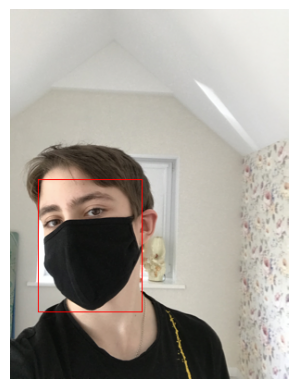

In [55]:
def plot_rect(image, label):
  image = image.copy()
  for i in range(len(label)):
    cv2.rectangle(image, (label[i][1], label[i][2]), (label[i][3], label[i][4]), (255, 0, 0), 1)
  plt.axis('off')
  plt.imshow(image)

plot_rect(images_data[0], labels_data[0])

array([[[224, 223, 215],
        [224, 221, 216],
        [224, 221, 216],
        ...,
        [240, 242, 238],
        [240, 242, 238],
        [241, 243, 240]],

       [[221, 221, 212],
        [223, 220, 215],
        [224, 221, 216],
        ...,
        [241, 242, 238],
        [241, 242, 238],
        [241, 243, 240]],

       [[222, 220, 213],
        [223, 220, 215],
        [223, 220, 215],
        ...,
        [240, 241, 237],
        [240, 242, 238],
        [241, 243, 240]],

       ...,

       [[ 27,  32,  28],
        [ 26,  30,  28],
        [ 26,  31,  28],
        ...,
        [207, 202, 213],
        [236, 233, 243],
        [247, 245, 253]],

       [[ 27,  33,  30],
        [ 28,  31,  31],
        [ 25,  31,  28],
        ...,
        [189, 184, 199],
        [230, 227, 236],
        [253, 249, 255]],

       [[ 26,  34,  29],
        [ 25,  31,  27],
        [ 23,  31,  26],
        ...,
        [185, 185, 195],
        [225, 226, 231],
        [249, 251, 253]]], dtype=uint8)
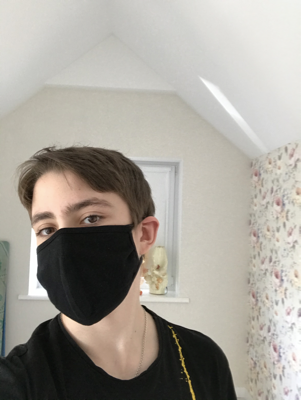

In [56]:
images_data[0]

In [57]:
labels_data[0]

[[1, 30, 184, 142, 327]]

In [58]:
df = pd.DataFrame({'image': images_data, 'label': labels_data})

In [59]:
df.iloc[0]

,0
image,"[[[224, 223, 215], [224, 221, 216], [224, 221,..."
label,"[[1, 30, 184, 142, 327]]"


In [60]:
# dic = {'other':0}

# for i in range(len(df['label'])):
#   for j in range(len(df['label'][i])):
#     if df['label'][i][j][0] not in dic:
#       dic[df['label'][i][j][0]] = 1
#     else:
#       dic[df['label'][i][j][0]] += 1

#print(dic) #{'other': 0, 'without_mask': 717, 'with_mask': 3232, 'mask_weared_incorrect': 123}

In [61]:
split = int(0.8*(len(df)))
train_df = df.iloc[:int(split)]
test_df = df.iloc[int(split):]

# Dataset & DataLoader

In [62]:
class FaceMaskDataset(torch.utils.data.Dataset):

  def __init__(self, df, transforms=None):
    self.df = df
    self.transform = transforms

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    image = self.df.iloc[index]['image']
    label = self.df.iloc[index]['label']

    bboxes = []
    labels = []
    for i in range(len(label)):
      bboxes.append(label[i][1:])
      labels.append(label[i][0])
    bboxes = bboxes[:10] if (len(bboxes) > 10) else bboxes + ([torch.zeros(4)] * (10 - len(bboxes)))
    labels = labels[:10] if (len(labels) > 10) else labels + ([0] * (10 - len(labels)))

    bboxes = torch.tensor(bboxes, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32)

    if self.transform:
      image = self.transform(image)

    return image, bboxes, labels

In [63]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [64]:
train_dataset = FaceMaskDataset(train_df, transforms=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = FaceMaskDataset(test_df, transforms=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [65]:
for images, bboxes, labels in train_dataloader:
  print(images.shape)
  print(bboxes.shape)
  print(labels.shape)
  break

torch.Size([64, 3, 224, 224])
torch.Size([64, 10, 4])
torch.Size([64, 10])


# Model Building

In [66]:
class FaceMaskModule(nn.Module):

  def __init__(self, faces = 5):
    super().__init__()
    self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    self.model.fc = nn.Identity()

    # bounding box for faces
    self.bboxes = nn.Linear(2048, faces * 4)

    # probability of each face
    self.labels = nn.Linear(2048, 3)


  def forward(self, x):
    x = self.model(x)

    #batch size = bboxes.size(0)
    bboxes = self.bboxes(x)
    bboxes = bboxes.view(bboxes.size(0), -1, 4)

    labels = self.labels(x)
    labels = labels.view(labels.size(0), -1)

    return bboxes, labels

In [67]:
model = FaceMaskModule(faces = 10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

FaceMaskModule(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [68]:
criterion_bbox = nn.SmoothL1Loss()
criterion_faces = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [69]:
for param in model.model.parameters():
  param.requires_grad = False

In [70]:
sum(p.numel() for p in model.parameters() if p.requires_grad) # with autograd true 23610482

102450

In [71]:
epochs = 10

# training loop
model.train()

for epoch in tqdm(range(epochs)):
  total_loss = 0
  for images, bboxes, labels in train_dataloader:
     images, bboxes, labels = images.to(device), bboxes.to(device), labels.to(device)

     optimizer.zero_grad()

     bboxes_pred, labels_pred = model(images)

     loss_bbox = criterion_bbox(bboxes_pred, bboxes)
     loss_faces = criterion_faces(labels_pred, labels)

     loss = loss_bbox + loss_faces

     loss.backward()
     optimizer.step()

     total_loss += loss.item()

  print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}")

 10%|█         | 1/10 [00:03<00:35,  3.97s/it]

Epoch [1/10], Loss: 698.4271


 20%|██        | 2/10 [00:08<00:32,  4.12s/it]

Epoch [2/10], Loss: 684.0247


 30%|███       | 3/10 [00:14<00:35,  5.01s/it]

Epoch [3/10], Loss: 674.1502


 40%|████      | 4/10 [00:18<00:27,  4.59s/it]

Epoch [4/10], Loss: 674.5070


 50%|█████     | 5/10 [00:22<00:22,  4.46s/it]

Epoch [5/10], Loss: 671.1705


 60%|██████    | 6/10 [00:26<00:17,  4.35s/it]

Epoch [6/10], Loss: 661.4534


 70%|███████   | 7/10 [00:30<00:12,  4.22s/it]

Epoch [7/10], Loss: 660.6402


 80%|████████  | 8/10 [00:34<00:08,  4.22s/it]

Epoch [8/10], Loss: 658.3108


 90%|█████████ | 9/10 [00:38<00:04,  4.20s/it]

Epoch [9/10], Loss: 646.0981


100%|██████████| 10/10 [00:42<00:00,  4.28s/it]

Epoch [10/10], Loss: 643.6389


In [120]:
def plot_rect2(image, bboxes):
  img = image.copy()
  img = transform(img)
  img = img.to(device)
  img = img.unsqueeze(0)
  bboxes_pred, labels_pred = model(img)
  bboxes_pred = bboxes_pred[0].cpu().detach().numpy()

  # for i in range(len(bboxes)):
  #   cv2.rectangle(image, (bboxes[i][1], bboxes[i][2]), (bboxes[i][3], bboxes[i][4]), (0, 255, 0), 1)
  for i in range(len(bboxes_pred)):
    x1, y1, x2, y2 = map(int, bboxes_pred[i])
    print((x1, y1), (x2, y2))
    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 1)
  plt.axis('off')
  plt.imshow(image)

(17, 18) (18, 19)
(11, 12) (12, 12)
(6, 6) (6, 6)
(4, 4) (5, 4)
(2, 2) (2, 2)
(1, 1) (1, 1)
(0, 0) (0, 0)
(0, 0) (0, 0)
(0, 0) (0, 0)
(0, 0) (0, 0)


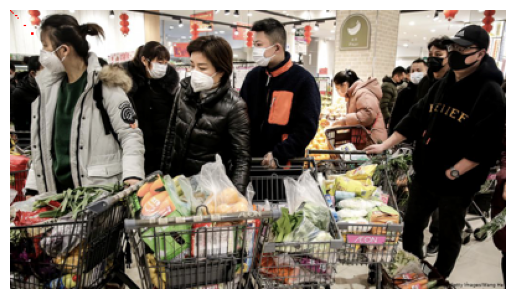

In [121]:
image = images_data[5]
label = labels_data[5]
# print(image)
plot_rect2(image, label)

In [74]:
# evaluation
# model.eval()

# for images, bboxes, labels in train_dataloader:
#      images, bboxes, labels = images.to(device), bboxes.to(device), labels.to(device)
